## Modern convnet architecture patterns: A mini Xception-like model

A model’s “architecture” is the sum of the choices that went into creating it: which layers to use, how to configure them, and in what arrangement to connect them. These choices define the hypothesis space of your model: the space of possible functions that gradient descent can search over, parameterized by the model’s weights. Like feature engineering, a good hypothesis space encodes prior knowledge that you have about the problem at hand and its solution. For instance, using convolution layers means that you know in advance that the relevant patterns present in your input images are translation-invariant. In order to effectively learn from data, you need to make assumptions about what you’re looking for.

Data augmentation, feature extraction and fine tuning are some techniques that we've already seen. Let's review some more...

### 1. Modularity, hierarchy, and reuse

If you want to make a complex system simpler, there’s a universal recipe you can apply: just structure your amorphous soup of complexity into modules, organize the modules into a hierarchy, and start reusing the same modules in multiple places as appropriate. It’s at the heart of the organization of any system of meaningful complexity, whether it’s a cathedral, your own body, the US Navy, or the Keras codebase.

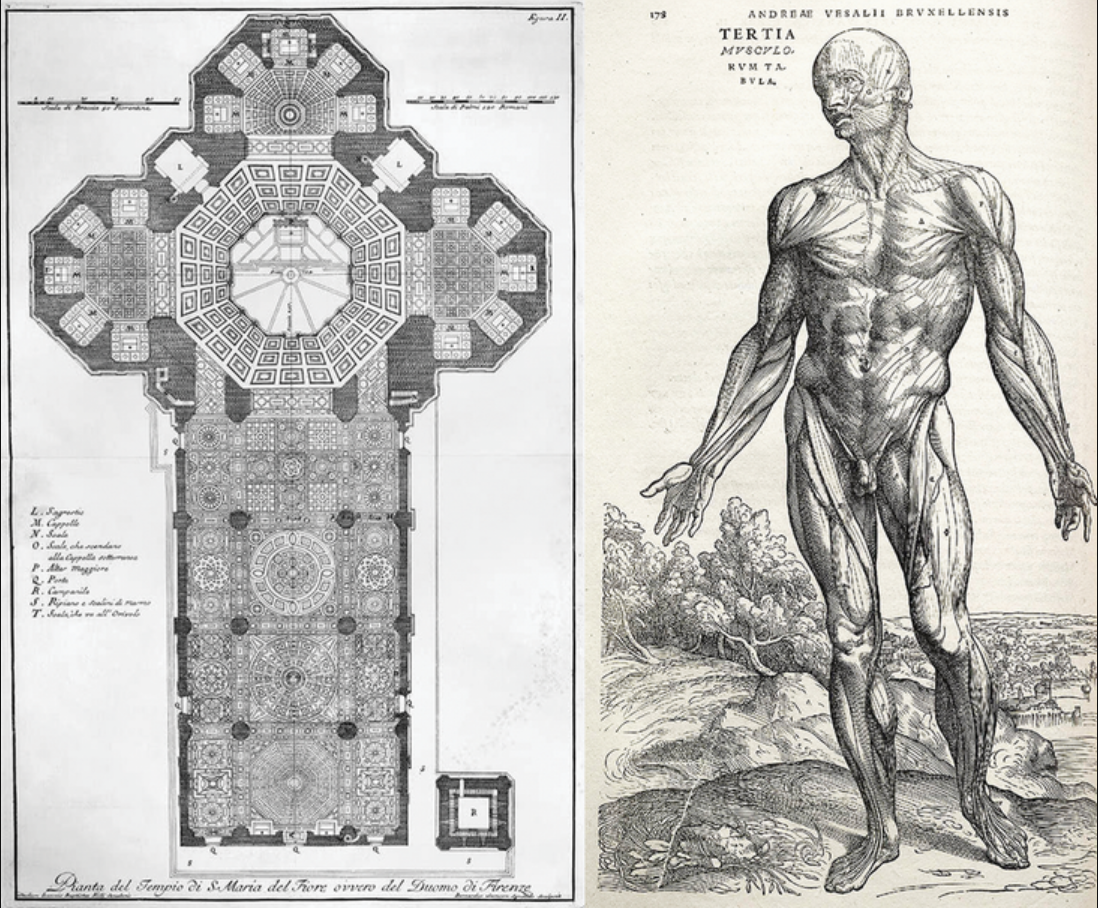

Recall, for example, the progression in the number of convolution filters we used in the first convnet we built in the previous chapter: 32, 64, 128. The number of filters grows with layer depth, while the size of the feature maps shrinks accordingly. You’ll notice the same pattern in the blocks of the VGG16 model.

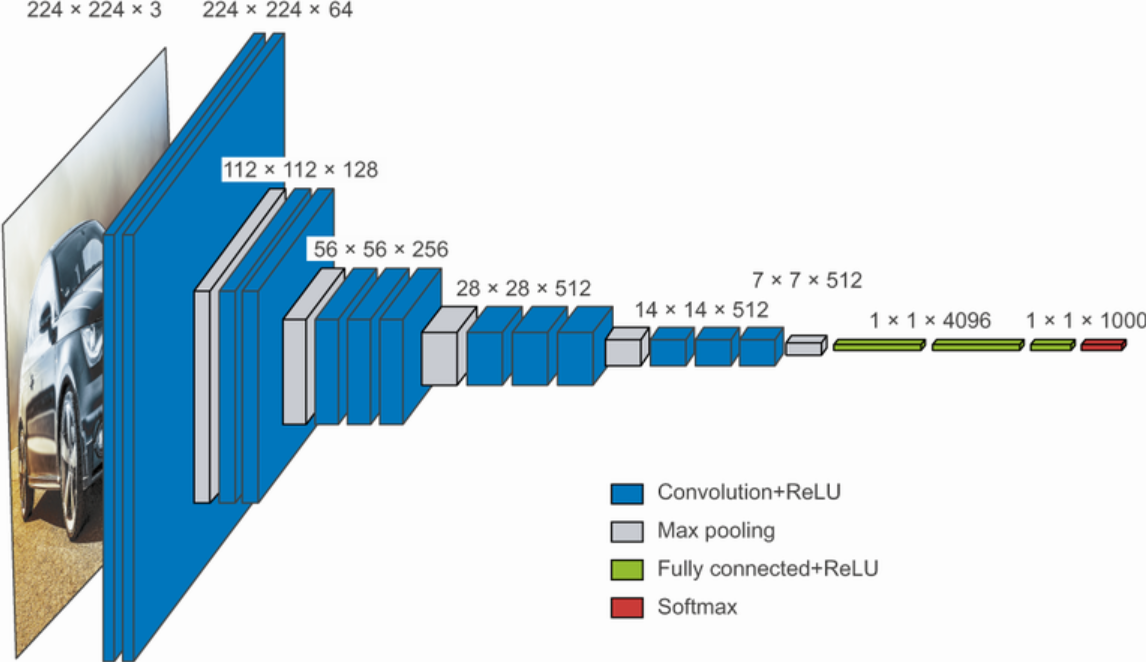

**Ablation studies**

An ablation study in machine learning involves systematically removing components (features, layers, modules, etc.) from a model to assess their individual contributions to overall performance. The idea is to isolate the impact of each part of the system by removing it and seeing what happens. This helps to understand which parts are essential for good performance and which ones might be redundant or even detrimental.

### 2. Residual connections

As it happens, backpropagation in a sequential deep learning model is pretty similar to the game of Telephone. You’ve got a chain of functions, like this one:

> y = f4(f3(f2(f1(x))))

The name of the game is to adjust the parameters of each function in the chain based on the error recorded on the output of f4 (the loss of the model). To adjust f1, you’ll need to percolate error information through f2, f3, and f4. However, each successive function in the chain introduces some amount of noise. If your function chain is too deep, this noise starts overwhelming gradient information, and backpropagation stops working. Your model won’t train at all. This is the vanishing gradients problem.

The fix is simple: just force each function in the chain to be nondestructive—to retain a noiseless version of the information contained in the previous input. The easiest way to implement this is to use a residual connection. It’s dead easy: just add the input of a layer or block of layers back to its output. The residual connection acts as an information shortcut around destructive or noisy blocks (such as blocks that contain relu activations or dropout layers), enabling error gradient information from early layers to propagate noiselessly through a deep network. This technique was introduced in 2015 with the ResNet family of models (developed by He at Microsoft).

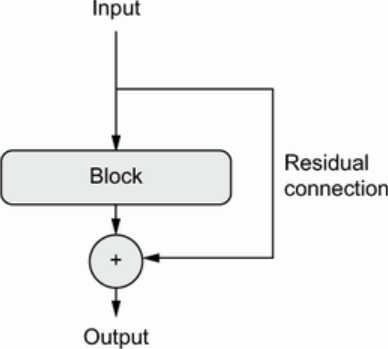


**Residual conection pseudocode**

> x = ...

> residual = x

> x = block(x)

> x = add([x, residual])


Note that adding the input back to the output of a block implies that the output should have the same shape as the input. However, this is not the case if your block includes convolutional layers with an increased number of filters, or a max pooling layer. In such cases, use a 1 × 1 Conv2D layer with no activation to linearly project the residual to the desired output shape. You’d typically use padding= "same" in the convolution layers in your target block so as to avoid spatial downsampling due to padding, and you’d use strides in the residual projection to match any downsampling caused by a max pooling layer.

In [ ]:
# Residual block where the number of filters changes

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x  #1
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) #2
residual = layers.Conv2D(64, 1)(residual) #3
x = layers.add([x, residual]) #4

# 1. Set aside the residual
# 2. This is the layer around which we create a residual connection: it increases the number of output filers from 32 to 64. Note that we use padding="same" to avoid downsampling due to padding.
# 3. The residual only had 32 filters, so we use a 1 × 1 Conv2D to project it to the correct shape.
# 4. Now the block output and the residual have the same shape and can be added.

In [2]:
# Residual block where the number of filters changes

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x  # 1
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  #2
x = layers.MaxPooling2D(2, padding="same")(x)  #2
residual = layers.Conv2D(64, 1, strides=2)(residual)  #3
x = layers.add([x, residual])  #4

# 1. Set aside the residual
# 2. This is the block of two layers around which we create a residual connection: it includes a 2 × 2 max pooling layer. Note that we use padding="same" in both the convolution layer and the max pooling layer to avoid downsampling due to padding.
# 3. We use strides=2 in the residual projection to match the downsampling created by the max pooling layer.
# 4. Now the block output and the residual have the same shape and can be added.

To make these ideas more concrete, here’s an example of a simple convnet structured into a series of blocks, each made of two convolution layers and one optional max pooling layer, with a residual connection around each block.

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):  #1
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)  #2
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)  #3
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)  #4
x = residual_block(x, filters=64, pooling=True)  #5
x = residual_block(x, filters=128, pooling=False)  #6

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


# 1. Utility function to apply a convolutional block with a residual connection, with an option to add max pooling
# 2. If we use max pooling, we add a strided convolution to project the residual to the expected shape.
# 3. If we don’t use max pooling, we only project the residual if the number of channels has changed.
# 4. First block
# 5. Second block; note the increasing filter count in each block.
# 6. The last block doesn’t need a max pooling layer, since we will apply global average pooling right after it.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_2[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │        128 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     18,496 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_2[… │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_13[0][0],  │
│                     │                   │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_4[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

With residual connections, you can build networks of arbitrary depth, without having to worry about vanishing gradients.

### 3. Batch normalization

Batch normalization is a type of layer (BatchNormalization in Keras) introduced in 2015 by Ioffe and Szegedy; it can adaptively normalize data even as the mean and variance change over time during training. During training, it uses the mean and variance of the current batch of data to normalize samples, and during inference (when a big enough batch of representative data may not be available), it uses an exponential moving average of the batch-wise mean and variance of the data seen during training.

The BatchNormalization layer can be used after any layer—Dense, Conv2D, etc.:

In [ ]:
# Pseudocode..
x = ...
x = layers.Conv2D(32, 3, use_bias=False)(x)  ### Because the output of the Conv2D layer gets normalized, the layer doesn’t need its own bias vector.
x = layers.BatchNormalization()(x)

**Note** Both Dense and Conv2D involve a bias vector, a learned variable whose purpose is to make the layer affine rather than purely linear. For instance, Conv2D returns, schematically, y = conv(x, kernel) + bias, and Dense returns y = dot(x, kernel) + bias. Because the normalization step will take care of centering the layer’s output on zero, the bias vector is no longer needed when using BatchNormalization, and the layer can be created without it via the option use_bias=False. This makes the layer slightly leaner.

It is recommended placing the previous layer’s activation after the batch normalization layer. So instead of doing what is shown in:

In [ ]:
# Pseudocode..
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

you would do what’s shown in

In [ ]:
# Pseudocode..
x = layers.Conv2D(32, 3, use_bias=False)(x)  # Note the lack of activation here.
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)  # We place the activation after the BatchNormalization layer.

### 4. Depthwise separable convolutions

What if I told you that there’s a layer you can use as a drop-in replacement for Conv2D that will make your model smaller (fewer trainable weight parameters) and leaner (fewer floating-point operations) and cause it to perform a few percentage points better on its task? That is precisely what the depthwise separable convolution layer does (SeparableConv2D in Keras). This layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1 × 1 convolution).

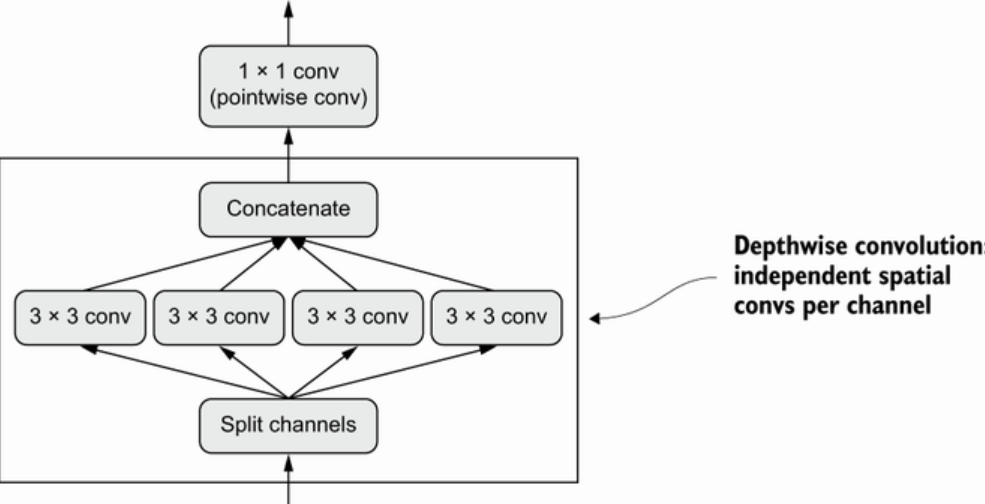

This is equivalent to separating the learning of spatial features and the learning of channel-wise features. In much the same way that convolution relies on the assumption that the patterns in images are not tied to specific locations, depthwise separable convolution relies on the assumption that spatial locations in intermediate activations are highly correlated, but different channels are highly independent.

### 5. Putting it together: A mini Xception-like model

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

base_dir = pathlib.Path(f"/tf-gpu/media/deep_learning_with_python/08_convnets_dogs_vs_cats/cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    color_mode="rgb",
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    color_mode="rgb",
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    color_mode="rgb",
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [5]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)  #1

for size in [32, 64, 128, 256, 512]:  #2
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)  #3
x = layers.Dropout(0.5)(x)  #4
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# 1. Note that the assumption that underlies separable convolution, “feature channels are largely independent,” does not hold for RGB images! Red, green, and blue color channels are actually highly correlated in natural images. As such, the first layer in our model is a regular Conv2D layer. We’ll start using SeparableConv2D afterwards.
# 2. We apply a series of convolutional blocks with increasing feature depth. Each block consists of two batch-normalized depthwise separable convolution layers and a max pooling layer, with a residual connection around the entire block.
# 3. In the original model, we used a Flatten layer before the Dense layer. Here, we go with a GlobalAveragePooling2D layer.
# 4. Like in the original model, we add a dropout layer for regularization.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 88, 88,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

This convnet has a trainable parameter count of 721,857, slightly lower than the 991,041 trainable parameters of the original model, but still in the same ballpark.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

In [7]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8750 - loss: 0.4277

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8561 - loss: 0.4488
Test accuracy: 0.854


You’ll find that our new model achieves a test accuracy of 85.4%, compared to 81.2% for the naive model in the last chapter. As you can see, following architecture best practices does have an immediate, sizable impact on model performance!

At this point, if you want to further improve performance, you should start systematically tuning the hyperparameters of your architecture.

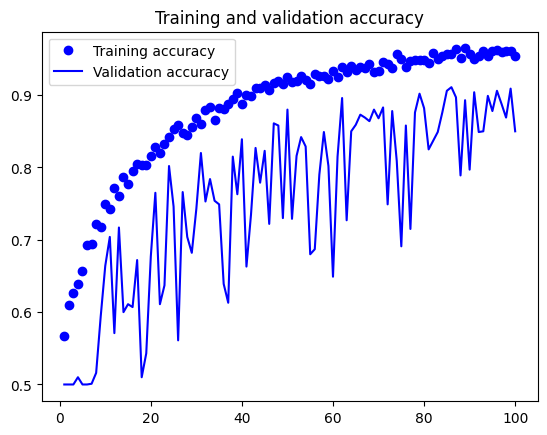

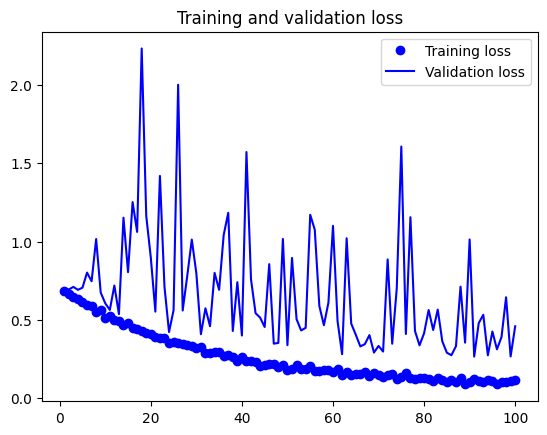

In [8]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()